In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from functools import partial

from pathlib import Path
from scipy.io import loadmat
from tqdm import trange, tqdm
from scipy.stats import ttest_ind
from collections import defaultdict as ddict
from easydict import EasyDict as edict

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# kmeans
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

from sklearn.decomposition import PCA

import holoviews as hv
from holoviews import opts, dim

%matplotlib inline
#hv.extension('matplotlib')
#hv.output(size=300, dpi=100)

In [2]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, RES_ROOT, DATA_ROOT

In [3]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, save_pkl, load_pkl

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_plotting

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import reorder_U, U_2brain_vec, obt_FC_exp

## Some fns

In [4]:
def get_sig_val_trans_curve(ecpts, sig_val):
    ecpts_full = np.concatenate([[0], ecpts, [7200]])
    sig_val_trans_vec = np.zeros(7200)
    for ix in range(len(ecpts_full)-1):
        low_idx, up_idx = ecpts_full[ix:(ix+2)].astype(int)
        sig_val_trans_vec[low_idx:up_idx] = sig_val[ix]
    return sig_val_trans_vec

In [5]:
def cpts_2dwells(cpts, bds=[0, 7200], fs=120):
    cpts_full = np.sort(np.concatenate([bds, cpts]))
    return np.diff(cpts_full)/fs

In [6]:

# update the count transited from one state to another. 
def update_trans_ct(cur_trans_ct, vec):
    for ix in range(len(vec)-1):
        from_ = vec[ix]
        to_ = vec[ix+1]
        cur_trans_ct[from_, to_] += 1
    return cur_trans_ct

In [46]:
# plot the corrmat with 7 canonical nets
def corr_plot(vecs, cutoff=0.05, trun_fn=None):
    vecs = np.array(vecs)
    if vecs.shape[0] != 68:
        vecs = vecs.T
    corrMat = np.zeros((7, vecs.shape[-1]))
    for ix in range(vecs.shape[-1]):
        curU = vecs[:, ix]
        if trun_fn is not None:
            curU = trun_fn(curU)
        for iy, kz in enumerate(kysOrd):
            curV = dict_nets7[kz]
            if trun_fn is not None:
                curV = trun_fn(curV)
            corr_v, pv = scipy.stats.pearsonr(curU, curV)
            if pv <= cutoff:
                corrMat[iy, ix] = corr_v
            else:
                corrMat[iy, ix] = 0
            
    plt.figure(figsize=[15, 5])
    abs_corrMat = np.abs(corrMat)
    sns.heatmap(abs_corrMat,  yticklabels=kysOrd, cmap="bwr", center=0, vmin=-1, vmax=1, annot=np.round(corrMat, 2))
    
    return corrMat

In [8]:
# truncate small value in vec
def cumsum_trunc(vec, cutoff=0.9):
    vec = vec.copy()
    idxs = cumsum_cutoff(vec, cutoff)
    counter_idxs = np.delete(np.arange(len(vec)), idxs)
    vec[counter_idxs] = 0
    return vec

In [61]:
# save the files for brainplotting
def save_brainplotting_vec(vecs, filname_prefix, is_csv=False):
    vecs = np.array(vecs)
    if vecs.shape[0] != 68:
        vecs = vecs.T
    for ix in range(vecs.shape[1]):
        cur_sing_vec = vecs[:, ix]
        out_vec_raw = minmax_plotting(cur_sing_vec)
        out_vec = U_2brain_vec(reorder_U(out_vec_raw))
        np.savetxt(RES_ROOT/f"./{filname_prefix}_{ix+1}.txt", out_vec)
        if is_csv:
            pd.DataFrame({"Name": REGION_NAMES,
                      "Vec": cur_sing_vec}).to_csv(RES_ROOT/f"./{filname_prefix}_{ix+1}.csv",
                                                          index=False)

##  Load data

In [15]:
results = load_pkl(RES_ROOT/"CPD_results_detect_first.pkl")

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method1/../../mypkg/../results/CPD_results_detect_first.pkl


In [16]:
cpts_ADs = results.AD.cpts 
candidate_pts_ADs = results.AD.candidate_pts 
ndXmats_AD = results.AD.ndXmats 
nXmats_AD = results.AD.nXmats 
CPDresult_AD = results.AD.CPDres 

cpts_ctrls = results.ctrl.cpts 
candidate_pts_ctrls = results.ctrl.candidate_pts 
ndXmats_ctrl = results.ctrl.ndXmats 
nXmats_ctrl = results.ctrl.nXmats 
CPDresult_ctrl = results.ctrl.CPDres 


B1 = CPDresult_ctrl[0]
B2 = CPDresult_ctrl[1]
com_Us = results.post_results.com_Us

# update parameters 
paras.update(results.paras)

In [230]:
np.savetxt(paras.res_dir/"Lambda_AD.txt", CPDresult_AD[-1])
np.savetxt(paras.res_dir/"Lambda_Ctrl.txt", CPDresult_ctrl[-1])

In [17]:
post_paras = results.post_paras

singular_vals_ADs = results.AD.singular_vals 
cpts_ADs_selected =  results.AD.cpts_selected 
dwells_ADs_selected =  results.AD.dwells_selected 
rank_ADs = results.AD.ranks 

singular_vals_ctrls = results.ctrl.singular_vals 
cpts_ctrls_selected =  results.ctrl.cpts_selected 
dwells_ctrls_selected =  results.ctrl.dwells_selected 
rank_ctrls = results.ctrl.ranks 

In [19]:
# load 7 cannonical nets
nets7_path = list(DATA_ROOT.glob("DK_dic68.csv"))[0]
nets7 = pd.read_csv(nets7_path).T

dict_nets7 = {}
for ix in range(nets7.shape[-1]):
    curCol = nets7[ix]
    dict_nets7[curCol[0]] = np.array(curCol[1:], dtype=float)
kysOrd = sorted(dict_nets7.keys())

In [49]:
for key, vec in dict_nets7.items():
    out_vec = U_2brain_vec(reorder_U(vec))
    np.savetxt(RES_ROOT/f"./cann_{key}.txt", out_vec)

In [20]:
dwells_AD = [cpts_2dwells(cpts) for cpts in cpts_ADs_selected]
dwells_ctrl = [cpts_2dwells(cpts) for cpts in cpts_ctrls_selected]

In [258]:
# AD from 1 to 88
n_sub = 88
dwells = dwells_AD
singular_vals = singular_vals_ADs

sub_idx_pool = np.concatenate([[ix+1]*len(dwells[ix]) for ix in range(n_sub)])
dwells_pool = np.concatenate(dwells)
singular_pool = np.concatenate(singular_vals, axis=1).T
data_all = np.concatenate([sub_idx_pool.reshape(-1, 1), dwells_pool.reshape(-1, 1), singular_pool], axis=1)
nams = ["sub_id", "dwells"] + [f"singluar_{ix}" for ix in range(1, 21)]
data_all = pd.DataFrame(data_all, columns=nams)
data_all.to_csv(paras.res_dir/"Lambda_segwise_wdwell_AD.csv", index=False)

In [260]:
# ctrl, from 1 to 88
n_sub = 88
dwells = dwells_ctrl
singular_vals = singular_vals_ctrls

sub_idx_pool = np.concatenate([[ix+1]*len(dwells[ix]) for ix in range(n_sub)])
dwells_pool = np.concatenate(dwells)
singular_pool = np.concatenate(singular_vals, axis=1).T
data_all = np.concatenate([sub_idx_pool.reshape(-1, 1), dwells_pool.reshape(-1, 1), singular_pool], axis=1)
nams = ["sub_id", "dwells"] + [f"singluar_{ix}" for ix in range(1, 21)]
data_all = pd.DataFrame(data_all, columns=nams)

data_all.to_csv(paras.res_dir/"Lambda_segwise_wdwell_ctrl.csv", index=False)

(20, 466)

## singular value (weights) analysis (Not good)

In [13]:
# note that I take abs of B3 for both grps
abs_B3_AD = np.abs(CPDresult_AD[-1])
abs_B3_ctrl = np.abs(CPDresult_ctrl[-1])
abs_B3_both = np.concatenate([abs_B3_AD, abs_B3_ctrl], axis=0)

In [14]:
# fit PCAs for AD and ctrl grps
pca_fit_AD = PCA(n_components=2)
pca_fit_AD.fit(abs_B3_AD)
pca_fit_ctrl = PCA(n_components=2)
pca_fit_ctrl.fit(abs_B3_ctrl)

pca_fit_both = PCA(n_components=2)
pca_fit_both.fit(abs_B3_both)

PCA(n_components=2)

In [15]:
# reduce the dim
singular_vals_ADs_red = [pca_fit_both.transform(np.abs(singular_vals_ADs[ix].T)) for ix in range(88)]
singular_vals_ctrls_red = [pca_fit_both.transform(np.abs(singular_vals_ctrls[ix].T)) for ix in range(88)]

In [16]:
sig_val_curves_AD = []
for ix in range(88):
    cur_curve = get_sig_val_trans_curve(cpts_ADs_selected[ix], 
                                        np.median(np.abs(singular_vals_ADs[ix]), axis=0))
    #cur_curve = get_sig_val_trans_curve(cpts_ADs_selected[ix], singular_vals_ADs_red[ix][:, 0])
    sig_val_curves_AD.append(cur_curve)
    
sig_val_curves_ctrl = []
for ix in range(88):
    cur_curve = get_sig_val_trans_curve(cpts_ctrls_selected[ix], 
                                        np.median(np.abs(singular_vals_ctrls[ix]), axis=0))
    #cur_curve = get_sig_val_trans_curve(cpts_ctrls_selected[ix], singular_vals_ctrls_red[ix][:, 0])
    sig_val_curves_ctrl.append(cur_curve)
    
sig_val_curves_AD = np.array(sig_val_curves_AD)
sig_val_curves_ctrl = np.array(sig_val_curves_ctrl)

In [17]:
center_vec = lambda x: x-x.mean()
plt_AD_vec = center_vec(np.median(sig_val_curves_AD, axis=0))
plt_ctrl_vec = center_vec(np.median(sig_val_curves_ctrl, axis=0))

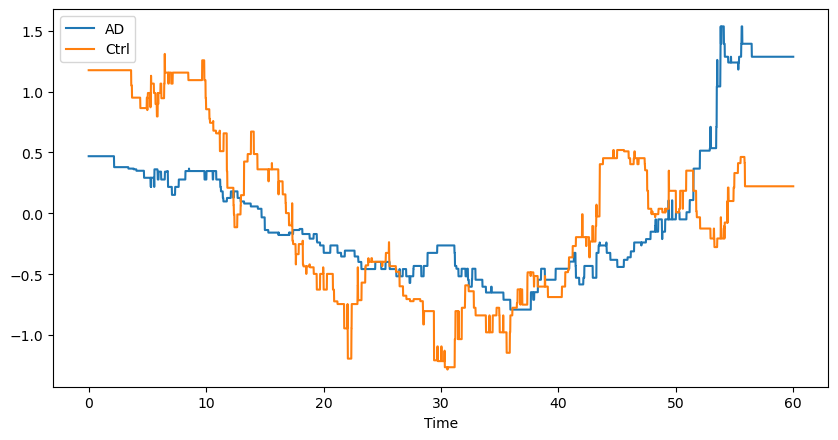

In [18]:
plt.figure(figsize=[10, 5], dpi=100)
times = np.linspace(0, 60, 7200)
plt.plot(times, plt_AD_vec, "-", label="AD")
plt.plot(times, plt_ctrl_vec, "-", label="Ctrl")
plt.xlabel("Time")
plt.legend()

## U analysis

### Save U for brain plot

In [116]:
save_brainplotting_vec(B1, "B1", True)
save_brainplotting_vec(np.abs(B1), "absB1")
save_brainplotting_vec(B2, "B2", True)

In [ ]:
top_ROIs = []
for ix in range(B1.shape[1]):
    cur_sing_vec = B1[:, ix]
    out_vec_raw = minmax(np.abs(cur_sing_vec))
    cur_sort_idx_top = np.argsort(-out_vec_raw)[:6]
    top_ROIs.append(region_names_lobes[cur_sort_idx_top])

pd.DataFrame(top_ROIs).to_csv(paras.res_dir/"Abs_Top_ROIs.csv")
#pd.DataFrame(top_ROIs).to_csv(paras.res_dir/"Raw_Top_ROIs.csv")

### Corrs with 7 nets

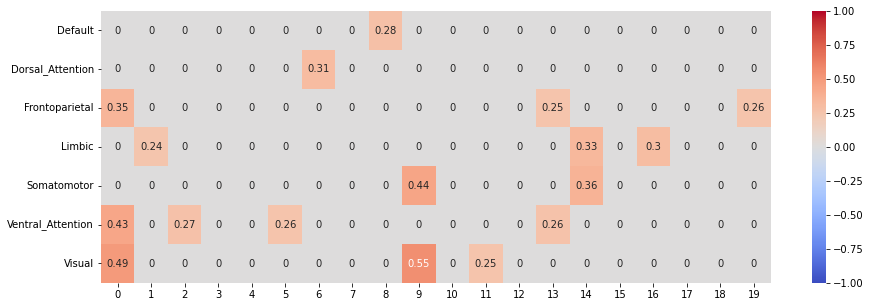

In [197]:
tfn1 = partial(cumsum_trunc, cutoff=0.9)
corr_mat = corr_plot(B1, trun_fn=tfn1)

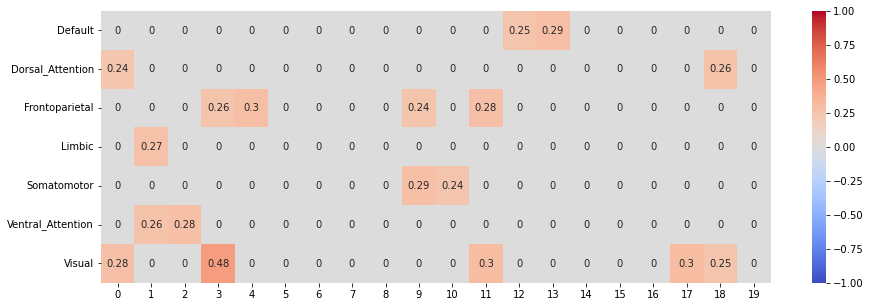

In [198]:
tfn1 = partial(cumsum_trunc, cutoff=0.9)
corr_mat = corr_plot(np.abs(B1), trun_fn=tfn1)

### FC analysis

#### Raw U

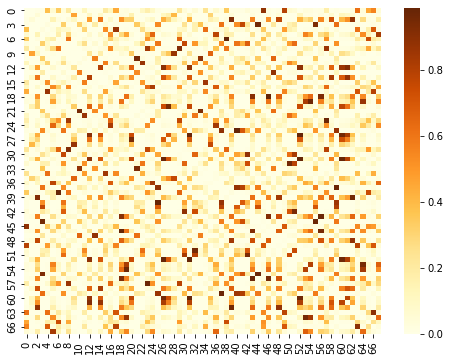

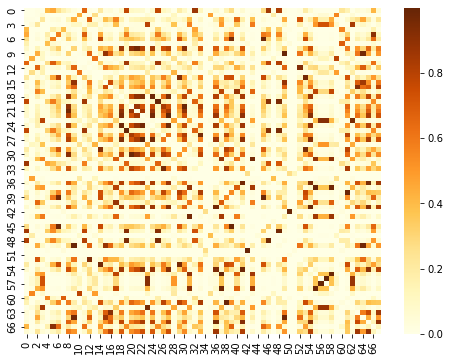

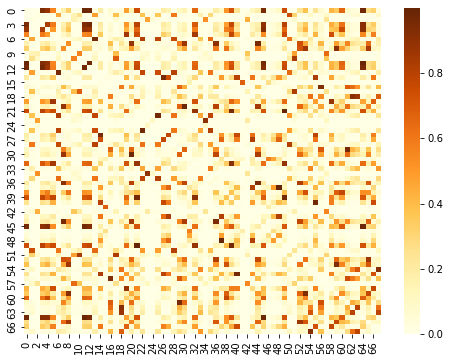

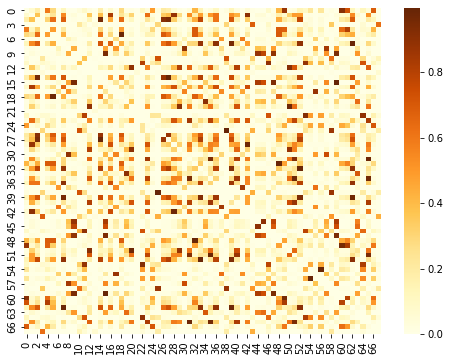

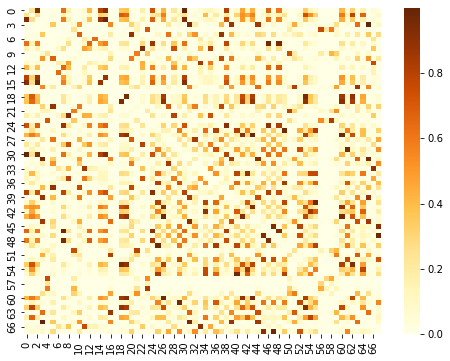

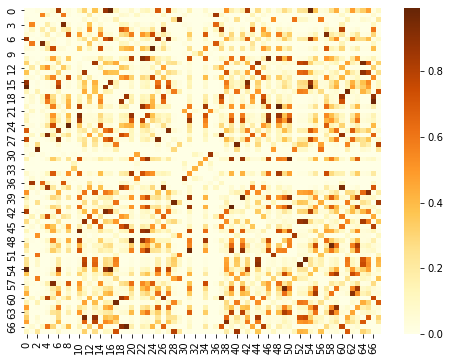

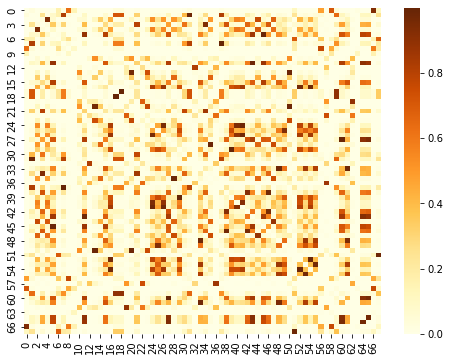

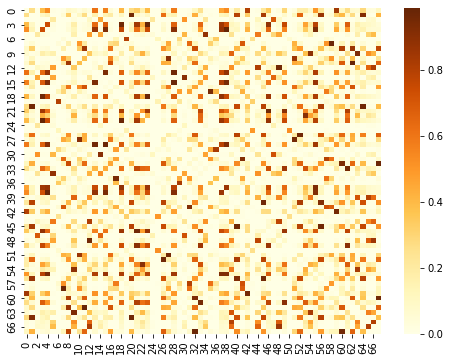

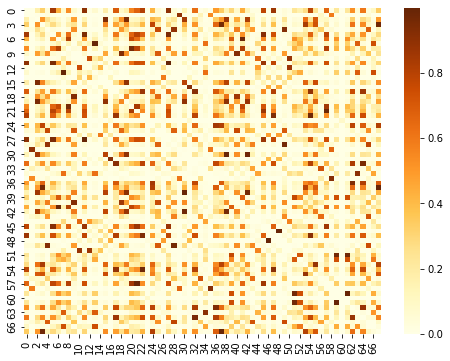

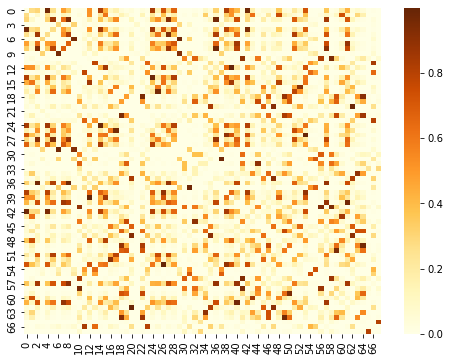

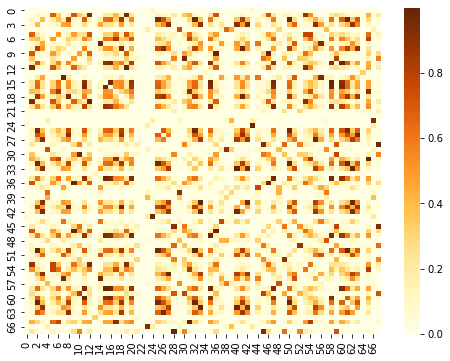

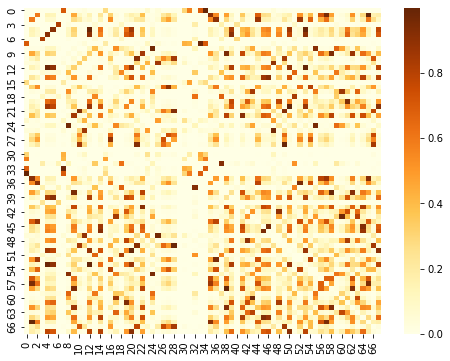

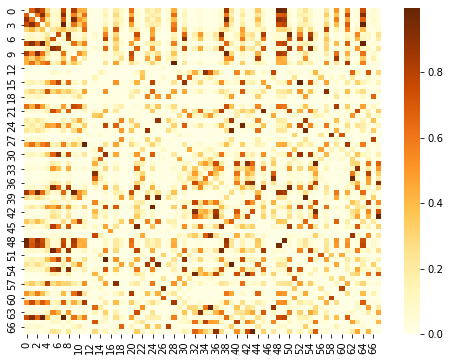

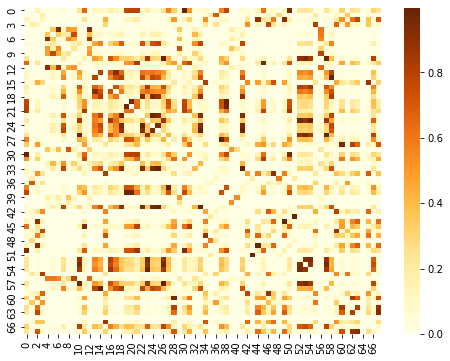

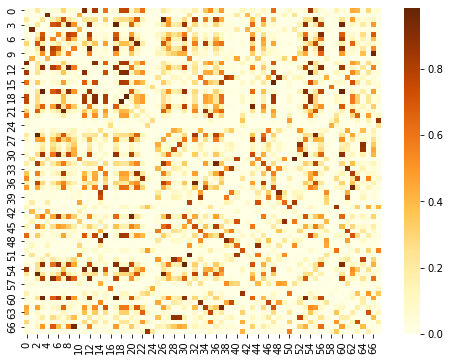

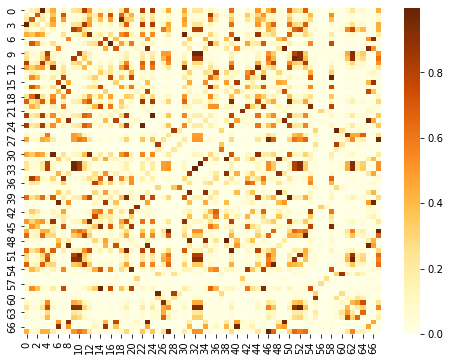

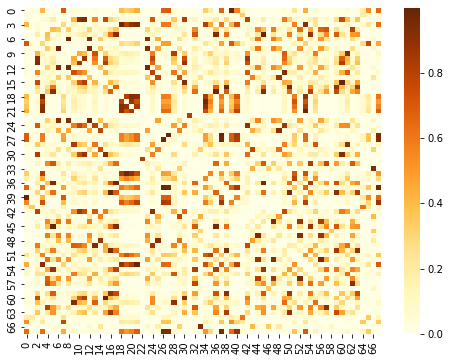

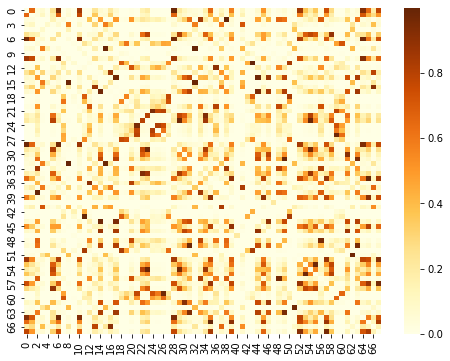

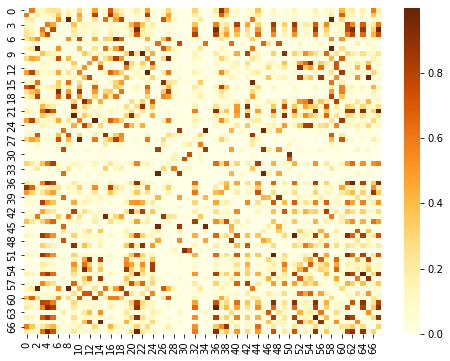

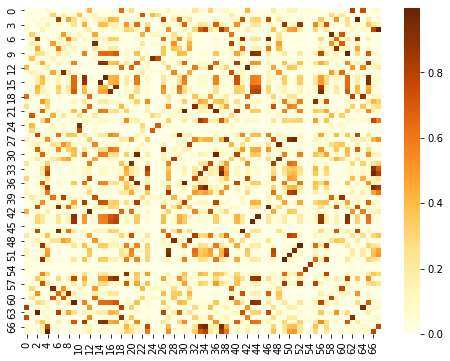

In [112]:
for ix in range(20):
    curU = np.array(B1[:, ix])
    FC = obt_FC_exp(curU, normalize=0.03)
    plt.figure(figsize=[8, 6])
    sns.heatmap(FC, cmap="YlOrBr")
    plt.savefig(paras.fig_dir/f"U_expFC_{ix+1}.jpg", bbox_inches='tight')

In [140]:
U_FC_top_eigmodes = []
for ix in range(20):
    curU = np.array(B1[:, ix])
    FC = obt_FC_exp(curU, normalize=0.03)
    res = eig_sorted(FC)
    top_eigmode = res[1][:, 0]
    print(np.abs(top_eigmode).min(), np.median(np.abs(top_eigmode)), np.max(np.abs(top_eigmode)))
    U_FC_top_eigmodes.append(np.abs(top_eigmode))

0.0010864351928364208 0.06021561895705116 0.2158138749569813
1.7384116965615492e-05 0.07680514162493521 0.20687150932937495
1.8728101964139854e-05 0.08397813581786576 0.22203604517664385
4.857862706428766e-06 0.06618160268067887 0.21577608590666872
7.668262553827031e-05 0.07768639706277544 0.21539906804920775
1.1963555687917937e-05 0.10052963240372961 0.197404981641209
6.743372453126661e-05 0.08941318232276943 0.1969589451912472
0.00012877142463351858 0.07350575029496867 0.23137152921061369
4.2538545578228775e-06 0.09413479848845696 0.19815127043463276
7.853705188573584e-05 0.057138953101632 0.2109556609827706
5.204947227460412e-07 0.090179391144708 0.1988074159507108
4.463097944160694e-06 0.08471916287968063 0.2025896543939838
1.4936069767325639e-05 0.11106986675800712 0.1835272460984616
2.9328926335738464e-06 0.08611089787564334 0.20465052170473053
0.00026231709273628754 0.1058888592355022 0.19643179730719487
9.698019799566202e-05 0.09472983628555777 0.20153002746311557
1.14467399483

In [141]:
save_brainplotting_vec(U_FC_top_eigmodes, filname_prefix="U_FC_top")

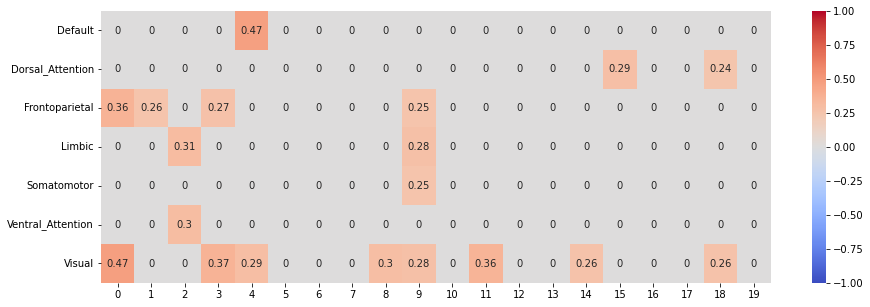

In [142]:
tfn1 = partial(cumsum_trunc, cutoff=1.5)
corr_mat = corr_plot(np.array(U_FC_top_eigmodes), trun_fn=tfn1)

#### AbsU

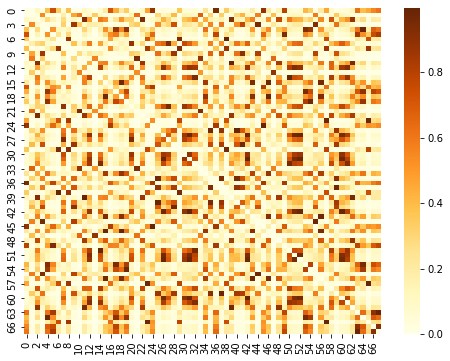

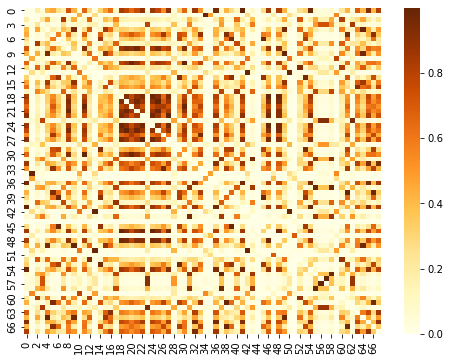

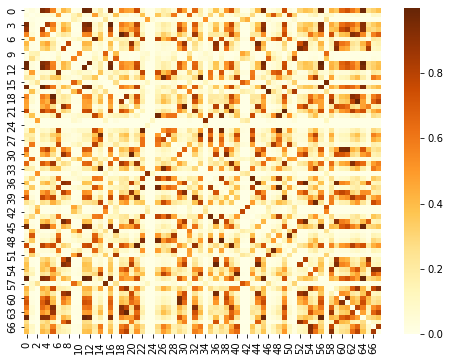

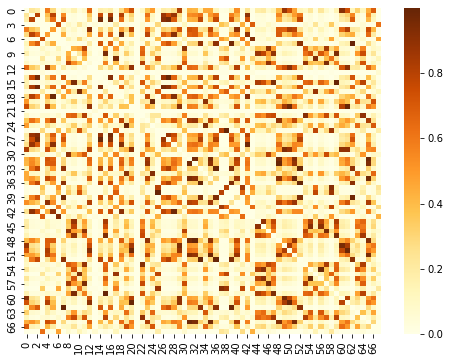

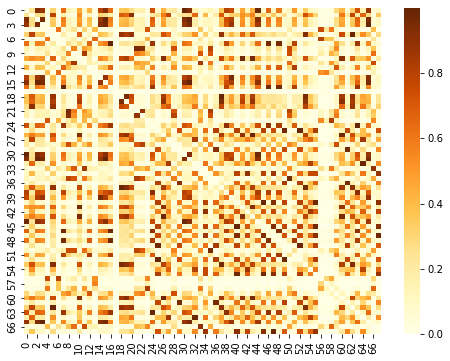

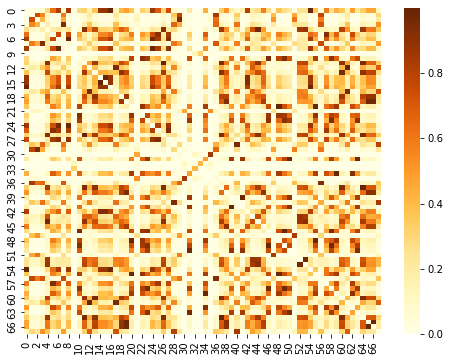

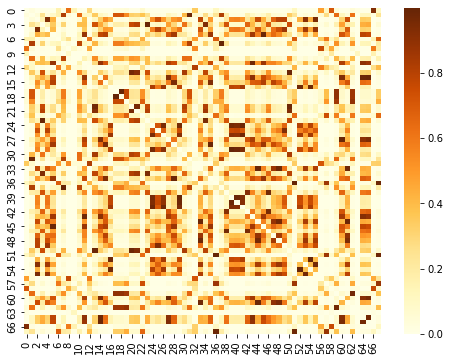

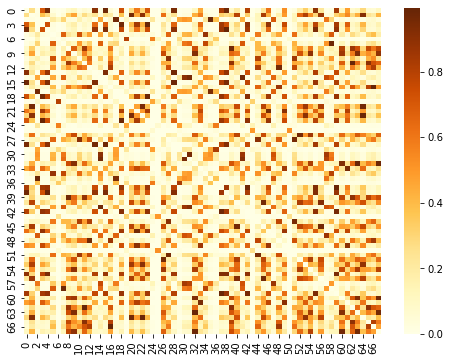

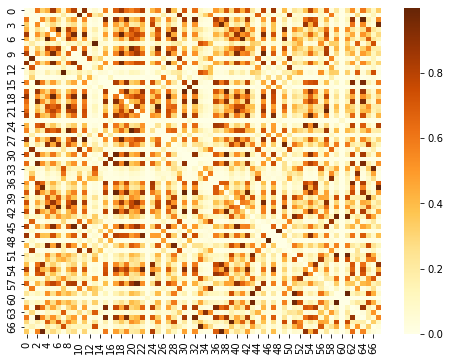

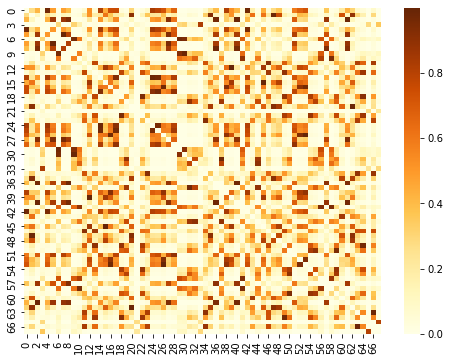

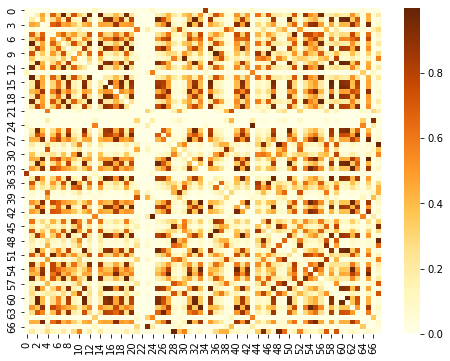

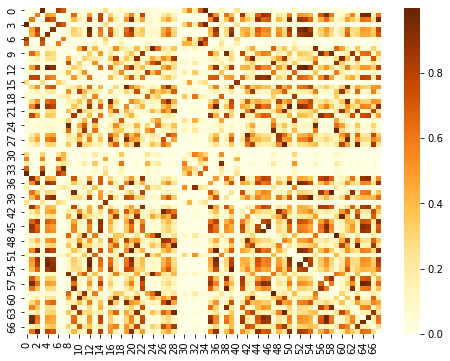

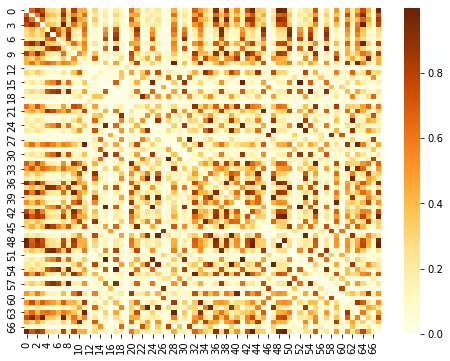

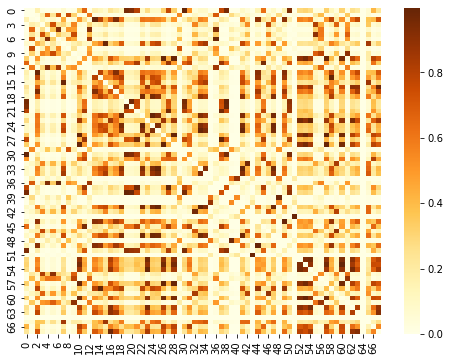

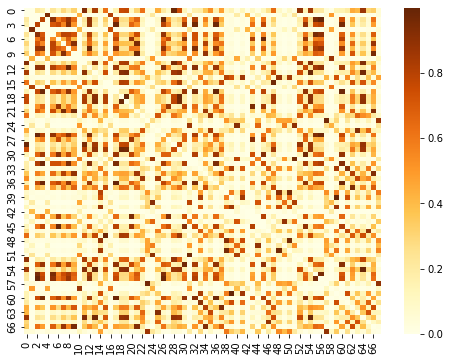

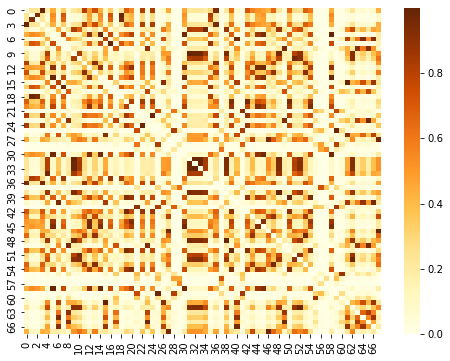

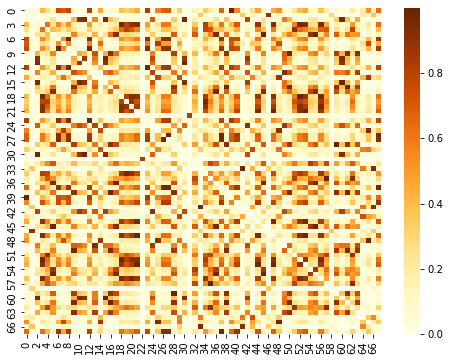

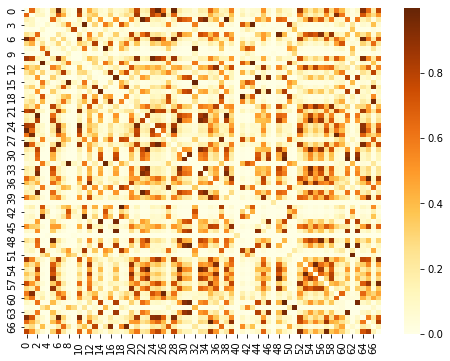

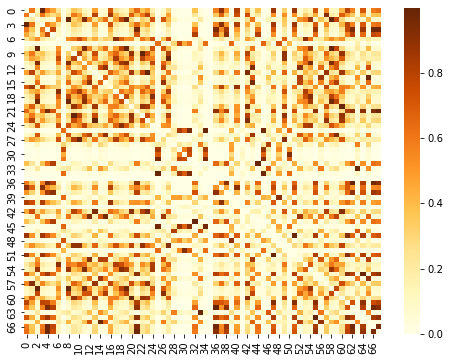

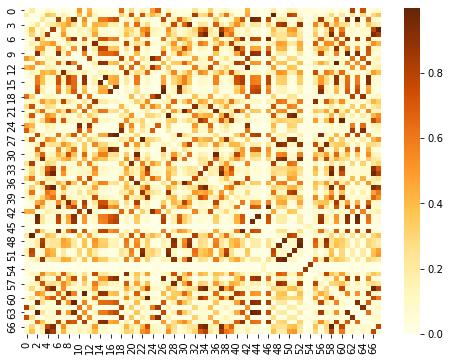

In [113]:
for ix in range(20):
    curU = np.abs(B1[:, ix])
    FC = obt_FC_exp(curU, normalize=0.03)
    plt.figure(figsize=[8, 6])
    sns.heatmap(FC, cmap="YlOrBr")
    plt.savefig(paras.fig_dir/f"absU_expFC_{ix+1}.jpg", bbox_inches='tight')

In [143]:
absU_FC_top_eigmodes = []
for ix in range(20):
    curU = np.abs(B1[:, ix])
    FC = obt_FC_exp(curU, normalize=0.03)
    res = eig_sorted(FC)
    top_eigmode = res[1][:, 0]
    print(np.abs(top_eigmode).min(), np.median(np.abs(top_eigmode)), np.max(np.abs(top_eigmode)))
    absU_FC_top_eigmodes.append(np.abs(top_eigmode))

0.020976922518471438 0.11606427666670893 0.1738040717644277
1.2261152229499487e-05 0.10980968546858734 0.18644735049898806
7.585360793994164e-05 0.11412285976720887 0.18419380985103437
1.9364924554713445e-05 0.10444775125615414 0.18493695562010273
7.79978336538698e-05 0.1138868219713783 0.17400002613767995
2.9591392497492978e-05 0.13216940751026424 0.1640341815020213
7.714968432299586e-05 0.12251269226715711 0.17708392987889518
0.00032299950162595283 0.13609652481614756 0.16267142338944482
3.818800457152694e-06 0.12464842649758076 0.17332565591102828
0.0007656369777305471 0.10929476976327376 0.1847929712770168
1.1152124057709615e-06 0.127594163156763 0.16658507258737512
1.4073536390603342e-05 0.11758015601472332 0.18098207917304415
2.4665299960907955e-05 0.12060302333225212 0.1742265011399123
3.6280226992608058e-06 0.11573312199027685 0.17323925916668384
0.0006738140367869204 0.12974979410140136 0.1825640232511249
0.0007490030260143283 0.13491546120948703 0.16638709948547922
1.76489670

In [144]:
save_brainplotting_vec(absU_FC_top_eigmodes, filname_prefix="absU_FC_top")

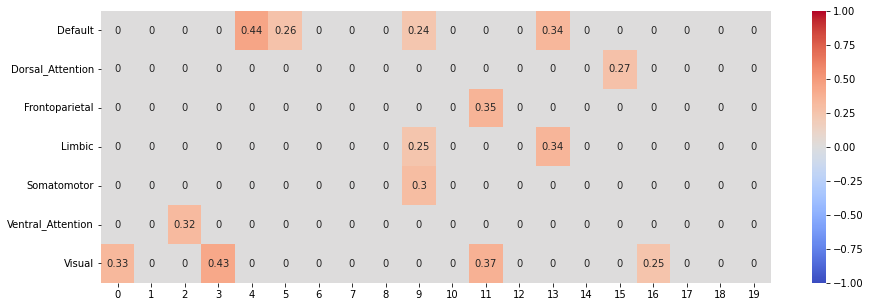

In [145]:
tfn1 = partial(cumsum_trunc, cutoff=1.8)
corr_mat = corr_plot(np.abs(absU_FC_top_eigmodes), trun_fn=tfn1)

### Dwell time x U

In [19]:
B1_idxs_AD = [np.argmax(np.abs(singular_vals), axis=0) for singular_vals in singular_vals_ADs]
B1_idxs_ctrl = [np.argmax(np.abs(singular_vals), axis=0) for singular_vals in singular_vals_ctrls]

In [21]:
dwells_AD = [cpts_2dwells(cpts) for cpts in cpts_ADs_selected]
dwells_ctrl = [cpts_2dwells(cpts) for cpts in cpts_ctrls_selected]

In [22]:
dwells_sigvec_AD = ddict(list)
for ix in range(len(singular_vals_ADs)):
    cur_dwells = dwells_AD[ix]
    cur_idxs = B1_idxs_AD[ix] +1 # adjust such that starting from 1 (not 0)
    [dwells_sigvec_AD[cur_idxs[ix]].append(cur_dwells[ix]) for ix in range(len(cur_idxs))]
    
dwells_sigvec_ctrl = ddict(list)
for ix in range(len(singular_vals_ctrls)):
    cur_dwells = dwells_ctrl[ix]
    cur_idxs = B1_idxs_ctrl[ix] +1 # adjust such that starting from 1 (not 0)
    [dwells_sigvec_ctrl[cur_idxs[ix]].append(cur_dwells[ix]) for ix in range(len(cur_idxs))]

In [23]:
sum_dwells = edict()
sum_dwells.AD = list()
sum_dwells.ctrl = list()

for ix in range(1, 21):
    sum_dwells.AD.append(np.sum(dwells_sigvec_AD[ix]))
    sum_dwells.ctrl.append(np.sum(dwells_sigvec_ctrl[ix]))

In [24]:
ratio_dwells = edict()
for type_ in ["AD", "ctrl"]:
    ratio_dwells[type_] = np.array(sum_dwells[type_])/np.sum(sum_dwells[type_])

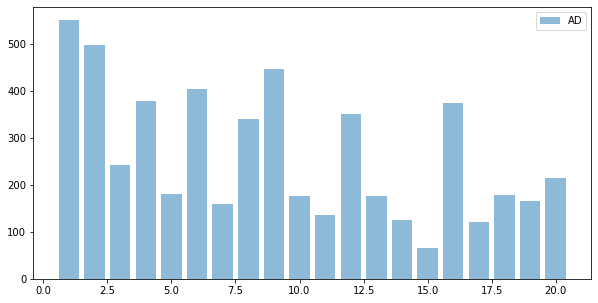

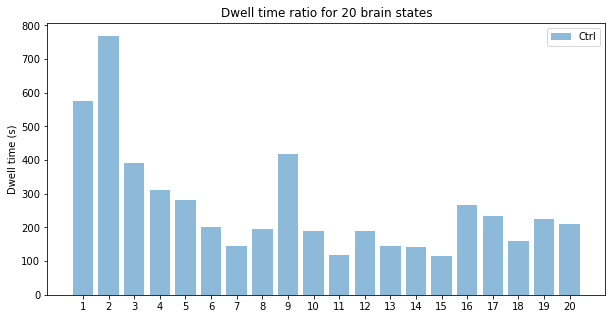

In [25]:
plt.figure(figsize=[10, 5])
plt.bar(list(range(1, 21)), sum_dwells["AD"], alpha=0.5, label="AD")
plt.legend()
plt.figure(figsize=[10, 5])
plt.bar(list(range(1, 21)), sum_dwells["ctrl"], alpha=0.5, label="Ctrl")
plt.title("Dwell time ratio for 20 brain states")
plt.ylabel("Dwell time (s)")
#plt.ylabel("Percentage (%)")
plt.xticks(list(range(1, 21)), list(range(1, 21)))
plt.legend()

### U state transition

In [29]:
trans_ct = edict()


cur_trans_ct = np.zeros((20, 20))
for ix in range(len(B1_idxs_AD)):
    cur_vec = B1_idxs_AD[ix]
    cur_trans_ct = update_trans_ct(cur_trans_ct, cur_vec)
trans_ct.AD = cur_trans_ct

cur_trans_ct = np.zeros((20, 20))
for ix in range(len(B1_idxs_ctrl)):
    cur_vec = B1_idxs_ctrl[ix]
    cur_trans_ct = update_trans_ct(cur_trans_ct, cur_vec)
trans_ct.ctrl = cur_trans_ct

<AxesSubplot:>

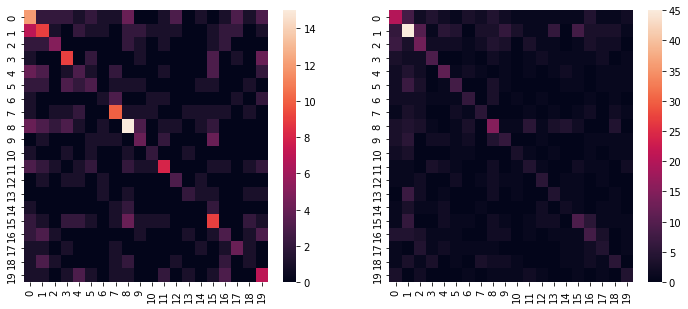

In [30]:
plt.figure(figsize=[12, 5])
plt.subplot(121)
sns.heatmap(trans_ct.AD)
plt.subplot(122)
sns.heatmap(trans_ct.ctrl)

#### Chord plot

In [31]:
def mat_2df(mat, include_diag=False, no_zero=True, cut_off=1):
    source = np.repeat(list(range(1, 21)), 20)
    target = np.repeat(np.arange(1,21).reshape(1,-1), 20, axis=0).reshape(-1)
    value = mat.flatten()
    idxs = source !=-100
    if not include_diag:
        idxs = np.bitwise_and(idxs, source != target)
    if no_zero:
        idxs = np.bitwise_and(idxs, value!=0)
    if cut_off is not None:
        idxs = np.bitwise_and(idxs, value>cut_off)
    source = source[idxs]
    target = target[idxs]
    value = value[idxs]
    res_df = pd.DataFrame({
        "source": source, 
        "target": target, 
        "value": value.astype(int)
    })
    return res_df

In [34]:
non_diag_mask = ~np.eye(20,dtype=bool)
cut_v = np.median(np.concatenate([trans_ct.AD[non_diag_mask], trans_ct.ctrl[non_diag_mask]]))

:Chord   [source,target]   (value)
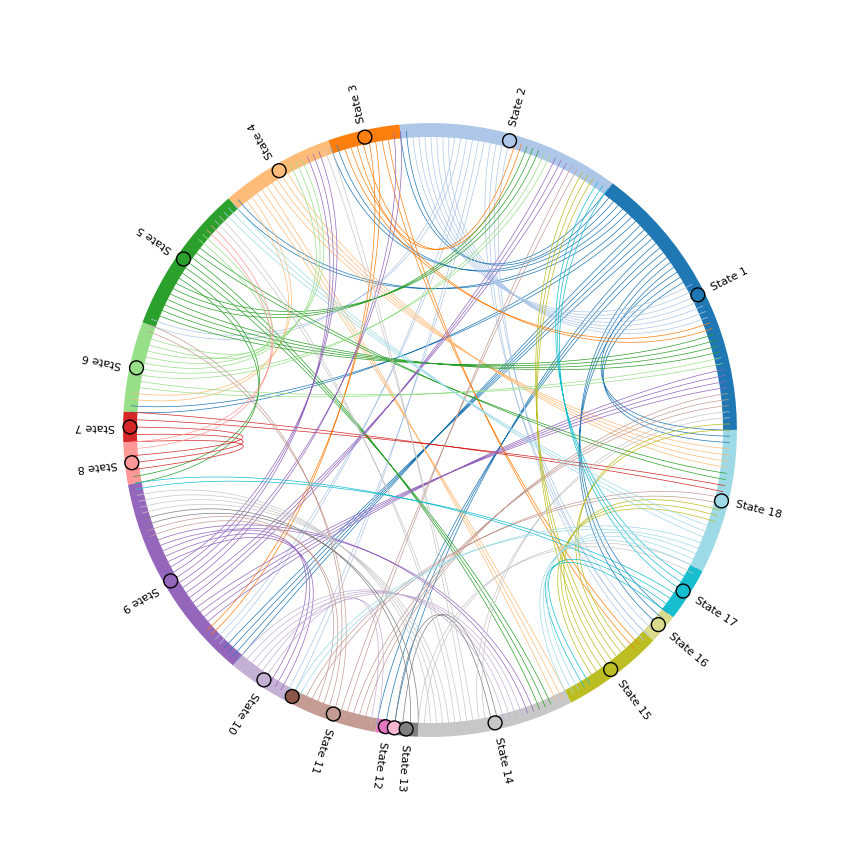

In [35]:
plt_data_AD = mat_2df(trans_ct.AD, cut_off=cut_v)
nodes = pd.DataFrame({
    "index": list(range(1, 21)),
    "name": [f"State {ix}" for ix in range(1, 21)]
})
nodes = hv.Dataset(nodes, "index")

chord = hv.Chord((plt_data_AD, nodes))
chord.opts(cmap='Category20', labels='name', 
           edge_color=dim('source').str(), 
           node_color=dim("index").str())

:Chord   [source,target]   (value)
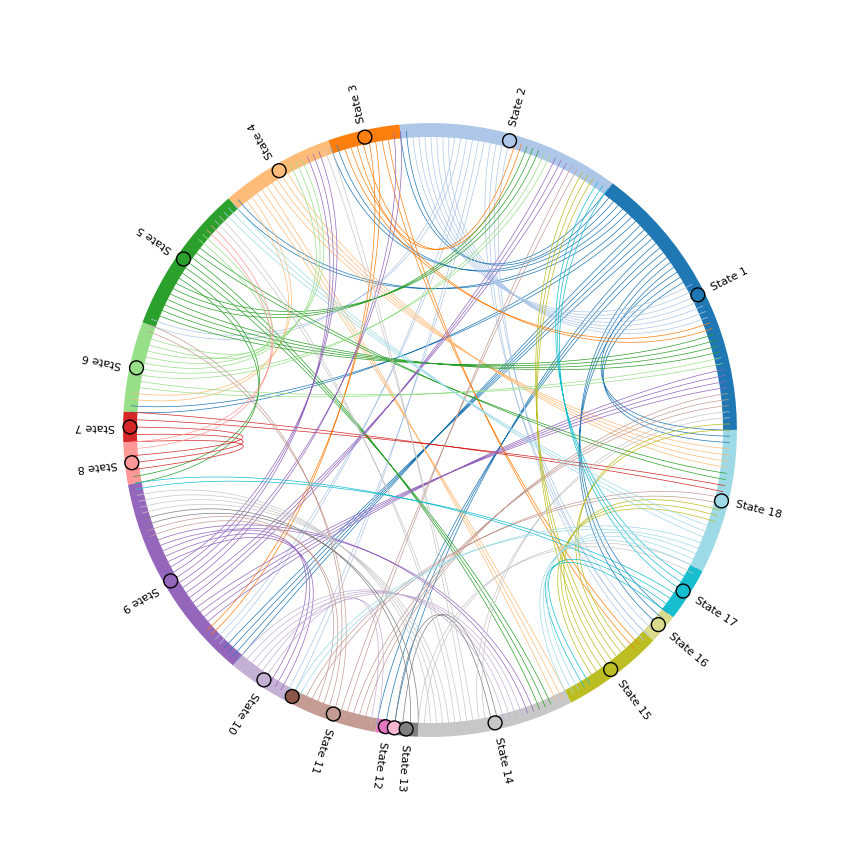

In [36]:
plt_data_AD = mat_2df(trans_ct.AD, cut_off=cut_v)
nodes = pd.DataFrame({
    "index": list(range(1, 21)),
    "name": [f"State {ix}" for ix in range(1, 21)]
})
nodes = hv.Dataset(nodes, "index")

chord = hv.Chord((plt_data_AD, nodes))
chord.opts(cmap='Category20', labels='name', 
           edge_color=dim('source').str(), 
           node_color=dim("index").str())

## wU analysis

###  Clustering singular values (abs)

In [21]:
# put all the singular values together
singular_vals_ADs_pool = np.abs(np.concatenate(singular_vals_ADs, axis=1))
singular_vals_ctrls_pool = np.abs(np.concatenate(singular_vals_ctrls, axis=1))
singular_vals_pool = np.concatenate([singular_vals_ADs_pool, singular_vals_ctrls_pool], axis=1)

In [238]:
np.savetxt(paras.res_dir/"Lambda_segwise_AD.txt", singular_vals_ADs_pool)
np.savetxt(paras.res_dir/"Lambda_segwise_Ctrl.txt", singular_vals_ctrls_pool)

In [204]:
# if not minmax, the clustering is poor
singular_vals_pool_mm = minmax_mat(singular_vals_pool, is_row=False)
singular_vals_ctrls_mm = minmax_mat(singular_vals_ctrls_pool, is_row=False)
singular_vals_ADs_mm = minmax_mat(singular_vals_ADs_pool, is_row=False)

In [22]:
singular_vals_ctrls_mm = singular_vals_ctrls_pool/np.linalg.norm(singular_vals_ctrls_pool,axis=0)
singular_vals_ADs_mm = singular_vals_ADs_pool/np.linalg.norm(singular_vals_ADs_pool,axis=0)

In [23]:
# find the best num of clusters
def kmeans_BIC(kmCluObj, Cn=1):
    nclu = kmCluObj.n_clusters
    nsps = len(kmCluObj.labels_)
    nDim = kmCluObj.cluster_centers_.shape[1]
    log_lik = np.log(kmCluObj.inertia_/nsps/nDim)
    BIC = log_lik + Cn*np.log(np.log(nsps*nDim))*np.log(nsps)*(nclu-1)/nsps
    #BIC = nsps*log_lik + np.log(nsps)*nclu*nDim/2
    #BIC = nsps*log_lik/(nsps-nDim*nclu)
    #BIC = nsps*log_lik + nclu*nDim
    return BIC

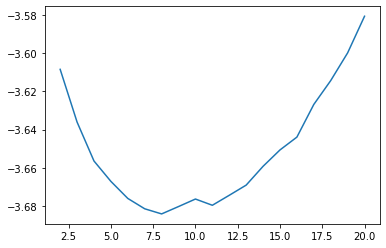

In [24]:
# tuning num of clus (not used)
n_cluss = np.array(list(range(2,21)))
BICs =[]
stds = []
for ix in n_cluss:
    cur_clus = KMeans(n_clusters=ix, random_state=0).fit(singular_vals_ctrls_mm.T)
    BICs.append(kmeans_BIC(cur_clus, 2))
    stds.append(np.std(np.unique(cur_clus.labels_, return_counts=True)[1]))
plt.plot(n_cluss, BICs)

In [56]:
n_clus = 8
#clus = SpectralClustering(n_clusters=n_clus, random_state=0).fit(singular_vals_pool_mm.T)
clus = KMeans(n_clusters=n_clus, random_state=0).fit(singular_vals_ctrls_mm.T)
ctrl_labs = clus.labels_
np.unique(clus.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([134,  69,  56,  80,  84,  60, 143, 133]))

In [57]:
d_mat = []
for ix in range(n_clus):
    cur_cens = clus.cluster_centers_[ix, :]
    d_mat.append(np.sum((singular_vals_ADs_mm.T- cur_cens)**2,axis=1))
d_mat = np.array(d_mat)
AD_labs = d_mat.argmin(axis=0)
np.unique(AD_labs, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([96, 30, 38, 61, 55, 60, 45, 81]))

### analysis

In [58]:
#clu_wU = []
#for ix in range(n_clus):
#    cur_wU = np.mean(singular_vals_ctrls_mm[:, clus.labels_==ix], axis=1)
#    clu_wU.append(cur_wU)
#clu_wU = np.array(clu_wU)
clu_wU = clus.cluster_centers_

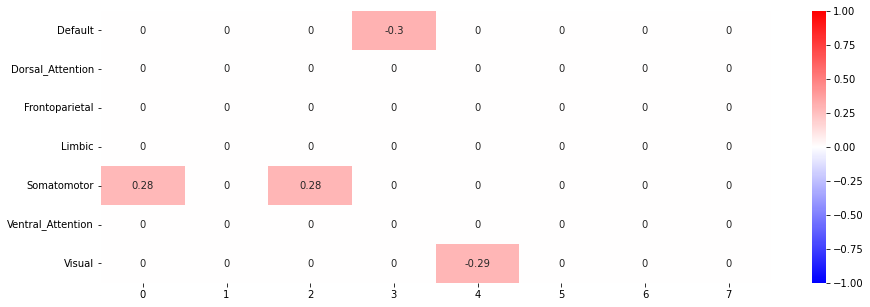

In [59]:
cens_wU = np.matmul(np.array(com_Us), clu_wU.T)
tfn1 = partial(cumsum_trunc, cutoff=1.99)
corr_plot(np.abs(cens_wU), cutoff=0.05, trun_fn=tfn1);

In [62]:
cens_wU = np.matmul(np.array(com_Us), clu_wU.T)
save_brainplotting_vec(cens_wU, "wxU", False)

In [63]:
cens_wU = np.matmul(np.array(com_Us), clu_wU.T)
save_brainplotting_vec(np.abs(cens_wU), "abswxU", False)

### Transition

In [50]:
flag = 0
AD_clu_labs = []
for cur_v in singular_vals_ADs:
    n_ele = cur_v.shape[1]
    AD_clu_labs.append(AD_labs[flag:(flag+n_ele)])
    flag += n_ele
    
flag = 0
ctrl_clu_labs = []
for cur_v in singular_vals_ctrls:
    n_ele = cur_v.shape[1]
    ctrl_clu_labs.append(ctrl_labs[flag:(flag+n_ele)])
    flag += n_ele

In [51]:
trans_ct = edict()

cur_trans_ct = np.zeros((n_clus, n_clus))
for ix in range(len(AD_clu_labs)):
    cur_vec = AD_clu_labs[ix]
    cur_trans_ct = update_trans_ct(cur_trans_ct, cur_vec)
trans_ct.AD = cur_trans_ct

cur_trans_ct = np.zeros((n_clus, n_clus))
for ix in range(len(ctrl_clu_labs)):
    cur_vec = ctrl_clu_labs[ix]
    cur_trans_ct = update_trans_ct(cur_trans_ct, cur_vec)
trans_ct.ctrl = cur_trans_ct

In [52]:
non_diag_mask = ~np.eye(n_clus,dtype=bool)

In [53]:
def mat_2df(mat, include_diag=False, no_zero=True, cut_off=None):
    source = np.repeat(list(range(1, 1+n_clus)), n_clus)
    target = np.repeat(np.arange(1,1+n_clus).reshape(1,-1), n_clus, axis=0).reshape(-1)
    value = mat.flatten()
    idxs = source !=-100
    if not include_diag:
        idxs = np.bitwise_and(idxs, source != target)
    if no_zero:
        idxs = np.bitwise_and(idxs, value!=0)
    if cut_off is not None:
        idxs = np.bitwise_and(idxs, value>cut_off)
    source = source[idxs]
    target = target[idxs]
    value = value[idxs]
    res_df = pd.DataFrame({
        "source": source, 
        "target": target, 
        "value": value.astype(int)
    })
    return res_df

In [57]:
nodes = pd.DataFrame({
    "index": list(range(1, n_clus+1)),
    "name": [f"State {ix}" for ix in range(1, n_clus+1)]
})
nodes = hv.Dataset(nodes, "index")

cut_v = np.median(np.concatenate([trans_ct.AD[non_diag_mask], trans_ct.ctrl[non_diag_mask]]))

:Chord   [source,target]   (value)
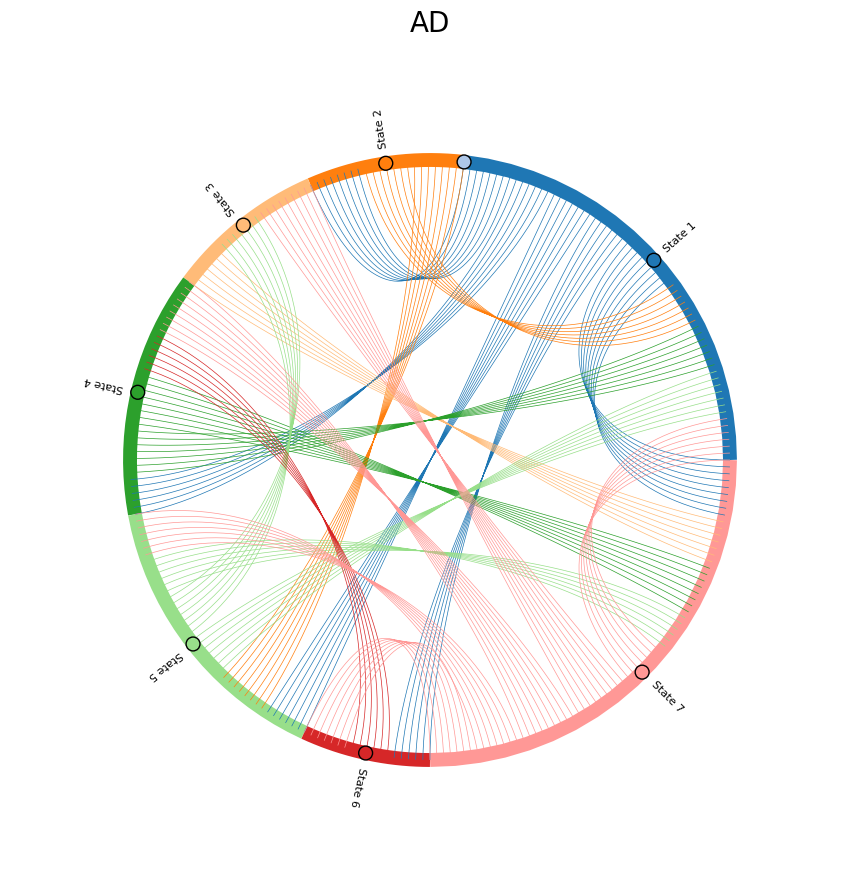

In [58]:
plt_data_AD = mat_2df(trans_ct.AD, False, cut_off=cut_v)

chord = hv.Chord((plt_data_AD, nodes))
chord.opts(cmap='Category20', labels='name', 
           title="AD", fontsize=20, 
           zrotation=45,
           edge_color=dim('source').str(), 
           node_color=dim("index").str())

:Chord   [source,target]   (value)
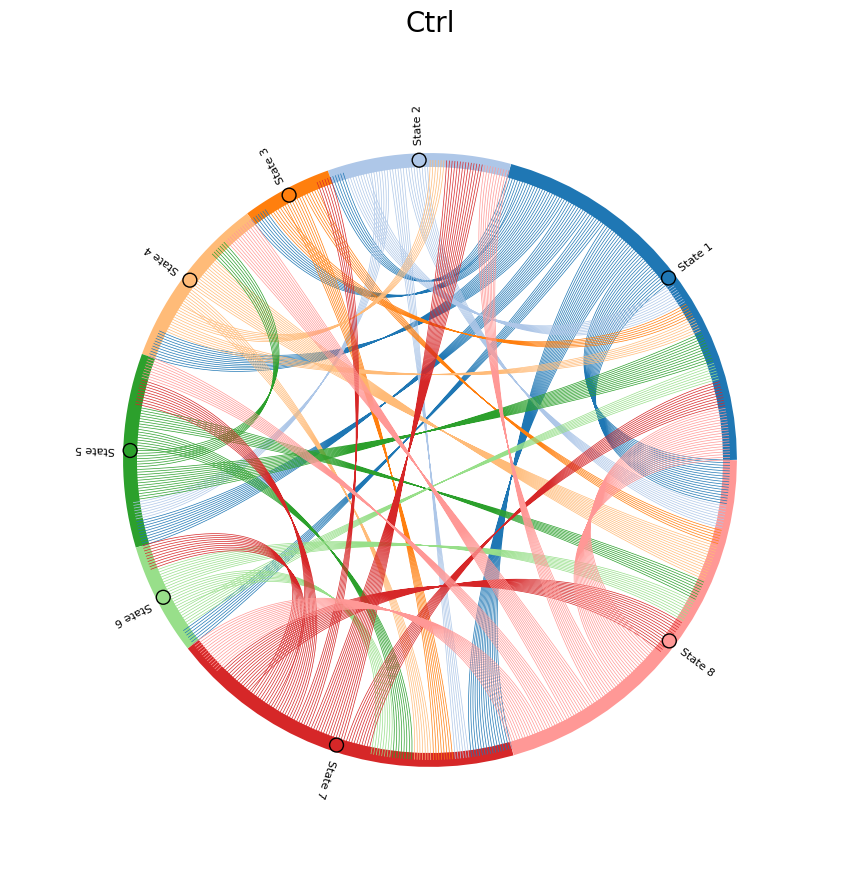

In [59]:
plt_data_ctrl = mat_2df(trans_ct.ctrl, False, cut_off=cut_v)

chord = hv.Chord((plt_data_ctrl, nodes))
chord.opts(cmap='Category20', labels='name', 
           title="Ctrl", fontsize=20, 
           edge_color=dim('source').str(), 
           node_color=dim("index").str())

### Dwell x wU

#### Each segment

In [60]:
dwells_AD = [cpts_2dwells(cpts) for cpts in cpts_ADs_selected]
dwells_ctrl = [cpts_2dwells(cpts) for cpts in cpts_ctrls_selected]

In [61]:
dwells_sigvec_AD = ddict(list)
for ix in range(len(singular_vals_ADs)):
    cur_dwells = dwells_AD[ix]
    cur_idxs = AD_clu_labs[ix] +1 # adjust such that starting from 1 (not 0)
    [dwells_sigvec_AD[cur_idxs[ix]].append(cur_dwells[ix]) for ix in range(len(cur_idxs))]
    
dwells_sigvec_ctrl = ddict(list)
for ix in range(len(singular_vals_ctrls)):
    cur_dwells = dwells_ctrl[ix]
    cur_idxs = ctrl_clu_labs[ix] +1 # adjust such that starting from 1 (not 0)
    [dwells_sigvec_ctrl[cur_idxs[ix]].append(cur_dwells[ix]) for ix in range(len(cur_idxs))]

In [62]:
sum_dwells = edict()
sum_dwells.AD = list()
sum_dwells.ctrl = list()

for ix in range(1, n_clus+1):
    sum_dwells.AD.append(np.sum(dwells_sigvec_AD[ix]))
    sum_dwells.ctrl.append(np.sum(dwells_sigvec_ctrl[ix]))

In [63]:
for ix in range(1, 9):
    print(scipy.stats.ttest_ind(dwells_sigvec_AD[ix], dwells_sigvec_ctrl[ix]))

Ttest_indResult(statistic=3.8299406845260613, pvalue=0.00016569257000307892)
Ttest_indResult(statistic=2.4514155524940606, pvalue=0.016018806896922325)
Ttest_indResult(statistic=1.2178263679305452, pvalue=0.2264041725079676)
Ttest_indResult(statistic=1.903821736688248, pvalue=0.059000264871452705)
Ttest_indResult(statistic=1.38164810104554, pvalue=0.16932876471125685)
Ttest_indResult(statistic=2.390608549809347, pvalue=0.018402498828867304)
Ttest_indResult(statistic=5.2162101463395025, pvalue=4.840502764428226e-07)
Ttest_indResult(statistic=3.656036985717152, pvalue=0.00032305399207025674)


In [64]:
ratio_dwells = edict()
for type_ in ["AD", "ctrl"]:
    ratio_dwells[type_] = np.array(sum_dwells[type_])/np.sum(sum_dwells[type_])

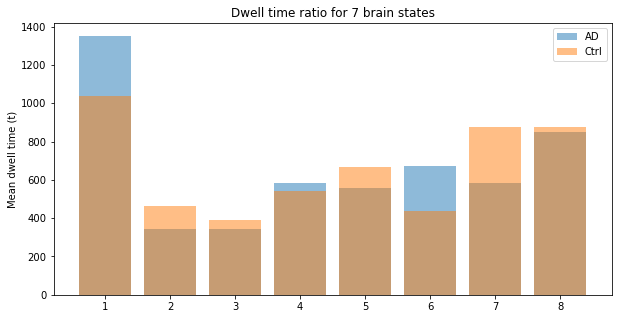

In [65]:
plt.figure(figsize=[10, 5])
plt.bar(list(range(1, n_clus+1)), sum_dwells["AD"], alpha=0.5, label="AD")
plt.bar(list(range(1, n_clus+1)), sum_dwells["ctrl"], alpha=0.5, label="Ctrl")
plt.title("Dwell time ratio for 7 brain states")
plt.ylabel("Mean dwell time (t)")
#plt.xticks(np.array(list(range(0, n_clus)))+0.5, states, rotation=45)
plt.legend()

####  each subject

In [66]:
# dwell time of each states for each subject
dwells_sigvec_AD_sub = []
for ix in range(len(singular_vals_ADs)):
    cur_dwells = dwells_AD[ix]
    cur_idxs = AD_clu_labs[ix] # adjust such that starting from 0 (not 1)
    dwells_sigvec_AD_sub.append([np.sum(cur_dwells[cur_idxs==iy]) for iy in range(n_clus)])
    
dwells_sigvec_ctrl_sub = []
for ix in range(len(singular_vals_ctrls)):
    cur_dwells = dwells_ctrl[ix]
    cur_idxs = ctrl_clu_labs[ix] # adjust such that starting from 0 (not 1)
    dwells_sigvec_ctrl_sub.append([np.sum(cur_dwells[cur_idxs==iy]) for iy in range(n_clus)])
    
dwells_sigvec_AD_sub = np.array(dwells_sigvec_AD_sub)
dwells_sigvec_ctrl_sub = np.array(dwells_sigvec_ctrl_sub)

In [67]:
dwells_subs = np.concatenate([dwells_sigvec_AD_sub, dwells_sigvec_ctrl_sub], axis=0)
dwells_subs_df = {f"State{ix+1}":dwells_subs[:, ix] for ix in range(n_clus)}
dwells_subs_df["group"] = ["AD"]*88 + ["ctrl"] * 88
dwells_subs_df = pd.DataFrame(dwells_subs_df)

In [68]:
dwells_subs_df.groupby("group").mean()

State1    State2    State3    State4    State5    State6    State7  \
group                                                                          
AD     15.351231  3.896402  3.920360  6.611174  6.312121  7.648011  6.604545   
ctrl   11.781155  5.242140  4.433333  6.167235  7.569981  4.944129  9.928788   

         State8  
group            
AD     9.656155  
ctrl   9.933239

In [69]:
for ix in range(n_clus):
    test_res = scipy.stats.ranksums(dwells_sigvec_AD_sub[:, ix], 
                                     dwells_sigvec_ctrl_sub[:, ix])
    print(test_res)

RanksumsResult(statistic=-0.2988427274787093, pvalue=0.765060047955801)
RanksumsResult(statistic=-2.3759476254000353, pvalue=0.01750394714530497)
RanksumsResult(statistic=-0.6050825521722382, pvalue=0.5451241467277258)
RanksumsResult(statistic=-0.3742931190698686, pvalue=0.708186250844475)
RanksumsResult(statistic=-0.9527461212687565, pvalue=0.3407187189388875)
RanksumsResult(statistic=0.6361503604744803, pvalue=0.5246784238995966)
RanksumsResult(statistic=-2.3300856226681543, pvalue=0.0198016261573193)
RanksumsResult(statistic=-1.3802983402853257, pvalue=0.1674948057865996)


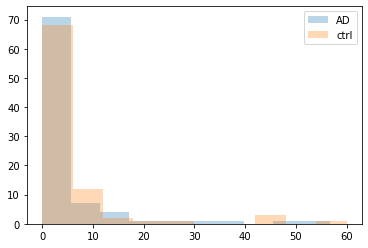

In [70]:
ix = 2
plt.hist(dwells_sigvec_AD_sub[:, ix], label="AD", alpha=0.3)
plt.hist(dwells_sigvec_ctrl_sub[:, ix], label="ctrl", alpha=0.3)
plt.legend()